Analysis of Anger in Posts

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from itertools import combinations
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from joblib import Parallel, delayed

Load data and specify dependent and independent variables

In [72]:
# Set display format for floating-point numbers
pd.set_option('display.float_format', '{:.8f}'.format)

# Load sentiment data
sentiments = pd.read_csv(
    "sentiment_results.csv",
    keep_default_na=False,  # avoid automatic conversion of strings like 'NA' to NaN
    na_values=['']          # treat only empty strings as NaN
)

# Define dependent and independent variables
dv = "Anger_p"
iv1 = "dominant_emotion_a"
iv2 = "NewsroomTopic"

Check the distribution of the dependent variable

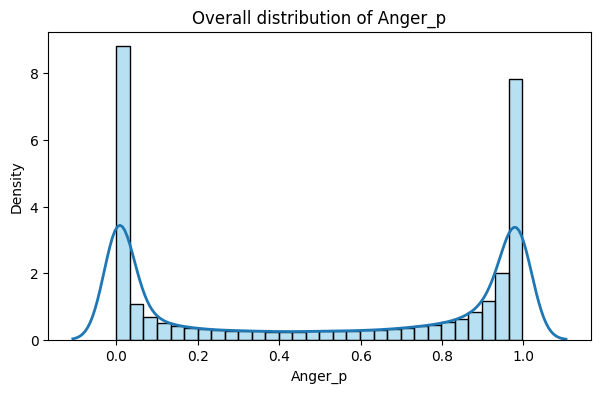

In [73]:
def check_distribution():
    # Drop NaNs from DV
    dv_data = sentiments[dv].dropna()

    # Plot original DV distribution
    plt.figure(figsize=(7, 4))
    sns.histplot(
        dv_data,
        bins=30,
        color='skyblue',
        edgecolor='black',
        alpha=0.6,
        stat='density'
    )
    sns.kdeplot(dv_data, lw=2)
    plt.title(f"Overall distribution of {dv}")
    plt.xlabel(dv)
    plt.ylabel("Density")
    plt.show()

check_distribution()

Check for homoskedacity of variances whitin main factors

In [74]:
def levene_test(iv):
    # Split data into groups by independent variable
    groups = [sentiments.loc[sentiments[iv] == lvl, dv] for lvl in sentiments[iv].unique()]

    # Perform Levene’s test (median-based) for equal variances
    stat, p = levene(*groups, center='median')
    print(f"Levene test for equal variances across {iv}:")

    # Interpret result
    if p < 0.05:
        print(f"  → ANOVA assumption of homoscedasticity is VIOLATED for {iv}.")
    else:
        print(f"  → ANOVA assumption of homoscedasticity is OK for {iv}.")

# Run Levene test for both independent variables
levene_test(iv1)
levene_test(iv2)

Levene test for equal variances across dominant_emotion_a:
  → ANOVA assumption of homoscedasticity is VIOLATED for dominant_emotion_a.
Levene test for equal variances across NewsroomTopic:
  → ANOVA assumption of homoscedasticity is VIOLATED for NewsroomTopic.


Perform bootstrapped testings to correct for violations of ANOVA assumptions

In [75]:
# Reproducibility seed
random_state = 8010

# Number of bootstrap samples
n_boot = 100

# Significance level for CIs
alpha = 0.05

Significant Labes are given if confidence intervals of effect sizes / mean differences exclude 0

1. ANOVA with bootstrapped eta_p2

Choose a dominant emotion threshold and filter data as preparation for ANOVA

In [76]:
# Values range from 0 to 1 - Reasonably it should be above 0.5
dominant_emotion_threshold = 2/3

In [77]:
def filter_emotion_threshold():
    # Filter rows where the dominant emotion exceeds the global threshold.
    print(f"Initial observations: {len(sentiments)}")

    # Dynamic column names based on dominant_emotion_a
    col_names = sentiments['dominant_emotion_a'] + '_a'
    col_idx = [sentiments.columns.get_loc(c) for c in col_names]
    row_idx = np.arange(len(sentiments))

    # Extract values and create mask
    values = sentiments.to_numpy()[row_idx, col_idx]
    mask = values > dominant_emotion_threshold
    anova_data = sentiments[mask]

    print(f"Observations after dominant emotion threshold filtering: {len(anova_data)}")
    return anova_data

#save filtered data in anova_data
anova_data = filter_emotion_threshold()

Initial observations: 249993
Observations after dominant emotion threshold filtering: 182489


Analysis of Variance for topic and emotions of articles on emotions of reactions

In [78]:
def bootstrap_anova():
    # Fit original two-way ANOVA model
    formula = f"{dv} ~ C({iv1}) + C({iv2})"
    model = smf.ols(formula, data=anova_data).fit()
    anova_df = anova_lm(model, typ=2).reset_index()

    # Residual sum of squares and df
    ss_error = anova_df.loc[anova_df['index'] == 'Residual', 'sum_sq'].values[0]
    df_error = int(model.df_resid)

    results_list = []

    for _, row in anova_df.iterrows():
        effect = row['index']
        if effect == 'Residual':
            continue

        df_effect = int(row['df'])
        F_orig = row['F']
        eta_p2_orig = row['sum_sq'] / (row['sum_sq'] + ss_error)

        # Parallel bootstrap function with deterministic seeds
        def single_boot(i):
            np.random.seed(random_state + i)  # deterministic seed per iteration
            df_boot = anova_data.sample(n=len(anova_data), replace=True)
            model_boot = smf.ols(formula, data=df_boot).fit()
            anova_boot = anova_lm(model_boot, typ=2)
            ss_error_boot = anova_boot.loc['Residual', 'sum_sq']
            ss_effect_boot = anova_boot.loc[effect, 'sum_sq']
            return ss_effect_boot / (ss_effect_boot + ss_error_boot)

        # Run bootstrap in parallel
        boot_eta = Parallel(n_jobs=-1)(delayed(single_boot)(i) for i in range(n_boot))

        # Confidence interval
        ci_lower = np.percentile(boot_eta, 100 * (alpha / 2))
        ci_upper = np.percentile(boot_eta, 100 * (1 - alpha / 2))
        significant = (ci_lower > 0) or (ci_upper < 0)

        results_list.append({
            "effect": effect,
            "F": F_orig,
            "eta_p2": eta_p2_orig,
            "eta_p2_ci_lower": ci_lower,
            "eta_p2_ci_upper": ci_upper,
            "df_effect": df_effect,
            "df_error": df_error,
            "significant": significant
        })

    return pd.DataFrame(results_list)

In [79]:
# Run bootstrap ANOVA and store results
anova_results = bootstrap_anova()
anova_results

,effect,F,eta_p2,eta_p2_ci_lower,eta_p2_ci_upper,df_effect,df_error,significant
0,C(dominant_emotion_a),76.46041892,0.00209071,0.00172027,0.00246544,5,182475,True
1,C(NewsroomTopic),205.17442440,0.00891499,0.00815735,0.00980880,8,182475,True


2. Post Hoc tests

Prepare Data by handeling small groups

In [80]:
# Choose whether to remove small groups
remove_small_groups = True

# Minimum group size for optional removal
min_group_size = 20

In [81]:
def remove_small_groups():
    
    pairwise_data = anova_data

    # Group sizes before filtering
    group_sizes_before = (
        pairwise_data
        .groupby([iv2, iv1])
        .size()
        .reset_index(name="n")
        .sort_values("n")
    )
    print(f"\nGroup sizes BEFORE small-group removal:")
    print(group_sizes_before)

    # Remove small groups if enabled
    if remove_small_groups:
        pairwise_data = pairwise_data.groupby([iv2, iv1]).filter(
            lambda x: len(x) >= min_group_size
        )
        print(f"\nRemoved groups with fewer than {min_group_size} observations")
    else:
        print("\nSmall-group removal disabled — no groups removed")

    # Group sizes after filtering
    group_sizes_after = (
        pairwise_data
        .groupby([iv2, iv1])
        .size()
        .reset_index(name="n")
        .sort_values("n")
    )
    print(f"\nGroup sizes AFTER small-group removal:")
    print(group_sizes_after)
    print(f"Remaining observations: {len(pairwise_data)}")

    return pairwise_data

# Save filtered data in pairwise_data
pairwise_data = remove_small_groups()


Group sizes BEFORE small-group removal:
    NewsroomTopic dominant_emotion_a      n
39     Wirtschaft                Joy      3
1            Etat            Disgust      4
18         Kultur                Joy      5
10         Inland            Sadness      5
46   Wissenschaft            Sadness      8
5            Etat            Sadness     11
8          Inland                Joy     16
42   Wissenschaft              Anger     25
41     Wirtschaft            Sadness     28
44   Wissenschaft                Joy     32
36            Web            Sadness     35
15  International            Sadness     46
34            Web                Joy     54
22       Panorama            Disgust     59
12  International            Disgust     60
3            Etat                Joy     90
16         Kultur              Anger     95
31          Sport            Sadness    104
26       Panorama            Sadness    161
20         Kultur            Sadness    169
27          Sport              Ange

In [82]:
def bootstrap_pairwise(iv):
    levels = pairwise_data[iv].unique()
    combs = list(combinations(levels, 2))
    results = []

    for a, b in combs:
        # Extract values for each group
        data_a = pairwise_data[pairwise_data[iv] == a][dv].values
        data_b = pairwise_data[pairwise_data[iv] == b][dv].values

        mean_a = data_a.mean()
        mean_b = data_b.mean()
        mean_diff = mean_a - mean_b

        # Parallel bootstrap function with deterministic seeds
        def single_boot(i):
            np.random.seed(random_state + i)  # deterministic seed per iteration
            sample_a = np.random.choice(data_a, size=len(data_a), replace=True)
            sample_b = np.random.choice(data_b, size=len(data_b), replace=True)
            return sample_a.mean() - sample_b.mean()

        # Run bootstrap in parallel
        diff_boot = Parallel(n_jobs=-1)(delayed(single_boot)(i) for i in range(n_boot))

        # Confidence interval
        ci_lower = np.percentile(diff_boot, 100 * (alpha / 2))
        ci_upper = np.percentile(diff_boot, 100 * (1 - alpha / 2))
        significant = (ci_lower > 0) or (ci_upper < 0)

        results.append({
            "group_a": a,
            "group_b": b,
            "mean_a": mean_a,
            "mean_b": mean_b,
            "mean_diff": mean_diff,
            "abs_mean_diff": abs(mean_diff),
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "significant": significant
        })

    return pd.DataFrame(results)

Pairwise comparison and bootstrap comparison of emotions

In [83]:
# Run bootstrap pairwise comparisons for iv1 and store results
emotion_results = bootstrap_pairwise(iv1)
print(f"Mean group difference: {np.mean(emotion_results['abs_mean_diff'])}, SD: {np.std(emotion_results['abs_mean_diff'])}")
emotion_results

Mean group difference: 0.12457199391412963, SD: 0.07589942121591932


,group_a,group_b,mean_a,mean_b,mean_diff,abs_mean_diff,ci_lower,ci_upper,significant
0,None,Fear,0.47714368,0.50885729,-0.03171361,0.03171361,-0.03747943,-0.02679523,True
1,None,Anger,0.47714368,0.59468349,-0.11753981,0.11753981,-0.12765244,-0.10691074,True
2,None,Joy,0.47714368,0.37708574,0.10005794,0.10005794,0.07208105,0.12523069,True
3,None,Sadness,0.47714368,0.30947054,0.16767315,0.16767315,0.12588981,0.19961077,True
4,None,Disgust,0.47714368,0.51401958,-0.03687589,0.03687589,-0.12839546,0.04613385,False
5,Fear,Anger,0.50885729,0.59468349,-0.08582620,0.08582620,-0.09294732,-0.07627217,True
6,Fear,Joy,0.50885729,0.37708574,0.13177155,0.13177155,0.10558028,0.16311646,True
7,Fear,Sadness,0.50885729,0.30947054,0.19938676,0.19938676,0.16763331,0.22556066,True
8,Fear,Disgust,0.50885729,0.51401958,-0.00516228,0.00516228,-0.08157638,0.07997799,False
9,Anger,Joy,0.59468349,0.37708574,0.21759775,0.21759775,0.19201105,0.23971404,True


Pairwise comparison and bootstrap comparison of topics

In [84]:
# Run bootstrap pairwise comparisons for iv2 and store results
topic_results = bootstrap_pairwise(iv2)
print(f"Mean group difference: {np.mean(topic_results['abs_mean_diff'])}, SD: {np.std(topic_results['abs_mean_diff'])}")
topic_results

Mean group difference: 0.0741964156290873, SD: 0.0555447278242944


,group_a,group_b,mean_a,mean_b,mean_diff,abs_mean_diff,ci_lower,ci_upper,significant
0,Wissenschaft,Web,0.43117584,0.48832027,-0.05714444,0.05714444,-0.06752902,-0.04717066,True
1,Wissenschaft,International,0.43117584,0.52745822,-0.09628238,0.09628238,-0.10722028,-0.08684141,True
2,Wissenschaft,Panorama,0.43117584,0.50844371,-0.07726787,0.07726787,-0.08674974,-0.06732338,True
3,Wissenschaft,Inland,0.43117584,0.54290337,-0.11172753,0.11172753,-0.12313516,-0.10226576,True
4,Wissenschaft,Sport,0.43117584,0.42949269,0.00168315,0.00168315,-0.01037324,0.01225988,False
5,Wissenschaft,Wirtschaft,0.43117584,0.54382833,-0.11265250,0.11265250,-0.12368640,-0.10342031,True
6,Wissenschaft,Etat,0.43117584,0.52794547,-0.09676963,0.09676963,-0.10867760,-0.08418588,True
7,Wissenschaft,Kultur,0.43117584,0.35317177,0.07800406,0.07800406,0.06388334,0.09087164,True
8,Web,International,0.48832027,0.52745822,-0.03913794,0.03913794,-0.04504963,-0.03114147,True
9,Web,Panorama,0.48832027,0.50844371,-0.02012344,0.02012344,-0.02708978,-0.01325638,True
